## WCF Modelling

This code:

- Import a CSV and create a random forest model
- Choose a location and download some satellite data
- Apply model to satellite image
- Do some plotting

#### Import modules

In [2]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten
from datacube_stats.statistics import GeoMedian
from dea_bandindices import calculate_indices

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV
import pickle

In [3]:
dc = datacube.Datacube(app='WCF')

#### Import training data csv

In [25]:
path = 'WCF_traindata_14122019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.680150,0.024840,0.038088,0.041936,0.20717,0.11010,0.062355
1,0.408790,0.043154,0.063489,0.069489,0.22708,0.17888,0.115670
2,0.000004,0.034636,0.064774,0.063311,0.32425,0.21022,0.111040
3,0.216960,0.032932,0.046541,0.050958,0.18029,0.17601,0.108140
4,0.434480,0.030078,0.046560,0.047636,0.20356,0.12678,0.073669


#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

Training data formatting

In [ ]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

Make a model

In [ ]:
# Define model
model = RandomForestRegressor(n_estimators=100, # number of trees in forest, is this equal to ensemble?
                              #criterion = 'mse', # function to measure the quality of the split
                              #max_depth = None, # max depth of tree. If None, then nodes are expanded until all laves are pure, or until all leaves contain less than min_samples_split
                              min_samples_split = 2, # Min no. samples required to be at a split node 
                              min_samples_leaf = 50, # Min no. samples required to be at a leaf node 
                              #min_weight_fraction_leaf = 0, # The min weighted fraction. Samples have equal weight when 0.
                              #max_features = 'auto', # The number of features to consider when looking for the best split
                              #max_leaf_nodes = None, # If None, then unlimited number of leaf nodes
                              #min_impurity_decrease = 0, # Split nodes to decrease impurity
                              #min_impurity_split = 1e-7, # Replaced by min_impurity_decrease
                              #bootstrap = true, # Whether to bootstrap samples when building trees. If False, the whole dataset is used ot build each tree.
                              #oob_score = False, # Whether to use out-of-bag samples to estimate R^2 on unseen data
                              #n_jobs = None, # The number of jobs to run in parallel. None means 1
                              random_state=30, # Controls the randomness of bootstrapping and the sampling of features to consider for bets node split
                              #verbose = 0, # Controls the verbosity when fititng and predicting
                              #warm_start = False, # False - fit new forest, True - reuse solution from previous call amd add more estimators to ensemble
                              #ccp_alpha = 0.0, # Complexity parameter
                              #max_samples = None, # If bootstrap is True, the numbe rof samples to draw from X to train each base estimator
                             )

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

#### Performance metrics

In draft:
- Root mean square estimate (RMSE) = 0.061
- Coefficient of determination (R^2) = 0.862
- Nash-Sutcliffe model efficiency (ME) = 0.862

In [ ]:
# Metrics
print('Explained variance score = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html
print('R^2 =')
print(metrics.r2_score(Y_test, prediction_test))
print('RMSE =')
print(metrics.mean_squared_error(Y_test, prediction_test))

#### Do some pickling

In [ ]:
# # Pickle this model
# pickle_out = open('pickled.pickle','wb')
# pickle.dump(model,pickle_out)
# pickle_out.close()

In [44]:
pickle_in = open('wcf_pickle.pickle','rb')
improved_grid_model = pickle.load(pickle_in)
print(improved_grid_model)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=30, verbose=0, warm_start=False)


## Apply the model to an image

### Choose location

Use custom area of interest:

In [4]:
# location = 'Canberra'

# # Set the central latitude and longitude
# central_lat = -35.434967
# central_lon = 149.002428

# # Set the buffer to load around the central coordinates
# buffer = 0.1

# # Compute the bounding box for the study area
# study_area_lat = (central_lat - buffer, central_lat + buffer)
# study_area_lon = (central_lon - buffer, central_lon + buffer)

# display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

Use LCCS test areas:

In [4]:
location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

location = 'Murray Valley'
min_x = 1100000
max_x = 1200000
min_y = -4000000
max_y = -3900000

location = 'Hobart'
min_x = 1200000
max_x = 1300000
min_y = -4800000
max_y = -4700000

In [48]:
# Make sure to change the location for in the save file
location = 'Hobart'
min_x = 1200000
max_x = 1300000
min_y = -4800000
max_y = -4700000

x = (min_x, max_x)
y = (min_y, max_y)

res_x = 25
res_y = -25

# Display an interactive map
display_map(x=x, y=y, crs='EPSG:3577', margin=-0.1) 

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Load in image collection

In [49]:
start_date = '2010'
end_date = '2015' 

#Load all data in baseline period available from Near Real Time data

i_col7 = dc.load(
              product=['ls7_nbart_geomedian_annual'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y)
              #resolution=(-50, 50),
              #group_by='solar_day'
)

i_col5 = dc.load(
              product=['ls5_nbart_geomedian_annual'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y)
              #resolution=(-50, 50),
              #group_by='solar_day'
)

In [50]:
# wofs_col = dc.load(
#               product=['wofs_annual_summary'],
#               x=x, #study_area_lon or x
#               y=y, #study_area_lat or y
#               time=(start_date, end_date),
#               #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
#               output_crs='EPSG:3577',
#               crs='EPSG:3577',
#               resolution=(res_x,res_y)
#               #resolution=(-50, 50),
#               #group_by='solar_day'
# )

In [51]:
# fc_col = dc.load(
#               product=['ls5_fc_albers','ls8_fc_albers'],
#               x=x, #study_area_lon or x
#               y=y, #study_area_lat or y
#               time=(start_date, end_date),
#               #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
#               output_crs='EPSG:3577',
#               crs='EPSG:3577',
#               resolution=(res_x,res_y)
#               #resolution=(-50, 50),
#               #group_by='solar_day'
# )

In [52]:
# fc_2010 = fc_col.sel(time='2010')#.median(dim='time')
# fc_2015 = fc_col.sel(time='2015')#.median(dim='time')
# fc_2010

In [53]:
# rgb(fc_2010.isel(time=0), bands=['BS', 'PV', 'NPV'])

In [54]:
# wofs_2010 = wofs_col.sel(time='2010')
# wofs_2015 = wofs_col.sel(time='2015')
# wofs_2010

Select images

<xarray.Dataset>
Dimensions:  (time: 1, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -4.8e+06 -4.8e+06 -4.8e+06 ... -4.7e+06 -4.7e+06
  * x        (x) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.2e+06 1.2e+06 1.2e+06
Data variables:
    blue     (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    green    (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    red      (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    nir      (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    swir1    (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    swir2    (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
Attributes:
    crs:      EPSG:3577
<xarray.Dataset>
Dimensions:  (time: 1, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -4.8e+06 -4.8e+06 -4.8e+06 ... -4.7e+06 -4.7e+06
  *

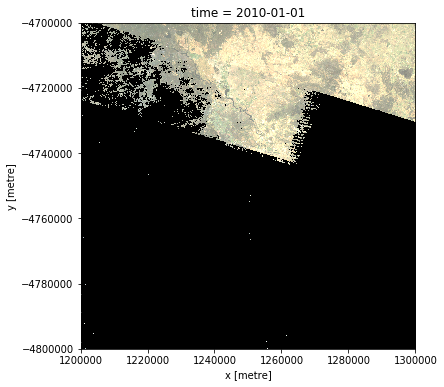

In [55]:
i_5 = i_col5.sel(time='2010')
i_7 = i_col7.sel(time='2010')
print(i_5)
print(i_7)
rgb(i_5, bands=['red','green','blue'])

In [56]:
i_5

<xarray.Dataset>
Dimensions:  (time: 1, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -4.8e+06 -4.8e+06 -4.8e+06 ... -4.7e+06 -4.7e+06
  * x        (x) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.2e+06 1.2e+06 1.2e+06
Data variables:
    blue     (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    green    (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    red      (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    nir      (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    swir1    (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
    swir2    (time, y, x) int16 -999 -999 -999 -999 -999 ... -999 -999 -999 -999
Attributes:
    crs:      EPSG:3577

In [57]:
s12 = np.where(i_5.red == 1, i_5, -999)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

### Predict WCF on image

Define a function to format image and run model over it

In [ ]:
def predict_wcf(image,model):
    flat = sklearn_flatten(image)
    flat = flat/10000
    results = model.predict(flat)
    print('Results:',results)
    unflat = (sklearn_unflatten(results,image).transpose())[0]
    return unflat

In [ ]:
wcf_5 = predict_wcf(i_5,improved_grid_model)
wcf_7 = predict_wcf(i_7,improved_grid_model)

In [ ]:
i_7

In [ ]:
wcf_7

In [ ]:
i5 = i_5.red.isel(time=0)

In [ ]:
# lifeform.values = np.where(predicted_wcf < 0.2, 2, lifeform.values)
wcf_5.values = np.where(i5 == -999, wcf_7.values, wcf_5.values)
# wcf_57 = wcf_5.where(i_5.red == -999, wcf_7)
wcf_5.plot(figsize=(10,10))

In [ ]:
wcf_7.plot(figsize=(5,5))

In [ ]:
wcf_5.plot(figsize=(5,5))

In [ ]:
masked = wcf_2010.where(i_2010.red != -999)
masked.plot(figsize=(10,10))
masked = masked.isel(time=0)
masked

In [ ]:
# # NBR
# nbr_2010 = (i_2010.nir - i_2010.swir2) / (i_2010.nir + i_2010.swir2)
# nbr_2015 = (i_2015.nir - i_2015.swir2) / (i_2015.nir + i_2015.swir2)

In [14]:
#list(dc.list_products()['name'])

### Plot the results

Woody cover in training data varies between 0 and 1

In [15]:
# fc_2010.median(dim='time')

NameError: name 'i_2010' is not defined

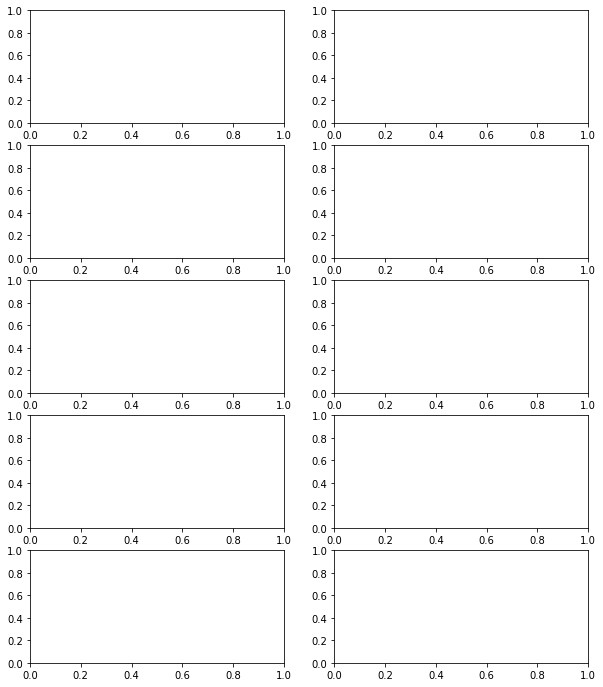

In [16]:
# Set up subplots
f, ax = plt.subplots(5, 2, figsize=(10,12), squeeze=False)

# before images
rgb(i_2010, bands=['red', 'green', 'blue'], ax=ax[0,0])
wcf_2010.plot(ax=ax[1,0],vmin=0,vmax=1)
nbr_2010.plot(ax=ax[2,0],vmin=0,vmax=1,cmap='Reds')
wofs_2010['frequency'].plot(ax=ax[3,0],vmin=0,vmax=1,cmap='Blues')
rgb(fc_2010,ax=ax[4,0], bands=['BS', 'PV', 'NPV'])

# after images
rgb(i_2015, bands=['red', 'green', 'blue'], ax=ax[0,1])
wcf_2015.plot(ax=ax[1,1],vmin=0,vmax=1)
nbr_2015.plot(ax=ax[2,1],vmin=0,vmax=1,cmap='Reds')
wofs_2015['frequency'].plot(ax=ax[3,1],vmin=0,vmax=1,cmap='Blues')
rgb(fc_2015, ax=ax[4,1], bands=['BS', 'PV', 'NPV'])


### Save results to Geotiff
To save results to geotiff for use and analysis in GIS software packages un comment the following Write_geotiff comands.

In [29]:
# 2010
wcf_2010_ds = wcf_5.to_dataset(name='wcf_2010').assign_attrs({'crs': 'EPSG:3577'})
write_geotiff(location+'_wcf_5.tif', wcf_2010_ds)

# 2015
wcf_2015_ds = wcf_7.to_dataset(name='wcf_2015').assign_attrs({'crs': 'EPSG:3577'})
write_geotiff(location+'_wcf_7.tif', wcf_2015_ds)

In [ ]:
# NBR
# 2010
nbr_2010_ds = nbr_2010.isel(time=0).to_dataset(name='nbr_2010')
write_geotiff(location+'_nbr_2010.tif', nbr_2010_ds)

# 2015
nbr_2015_ds = nbr_2015.isel(time=0).to_dataset(name='nbr_2015')
write_geotiff(location+'_nbr_2015.tif', nbr_2015_ds)

In [ ]:
# Frequency
# 2010
wofs_2010_ds = wofs_2010['frequency'].isel(time=0).to_dataset(name='wofs_2010')
write_geotiff(location+'_wofs_2010.tif', wofs_2010_ds)

# 2015
wofs_2015_ds = wofs_2015['frequency'].isel(time=0).to_dataset(name='wofs_2015')
write_geotiff(location+'_wofs_2015.tif', wofs_2015_ds)

In [ ]:
# Fractional Cover
# 2010
fc_2010_ds = fc_2010['frequency'].isel(time=0).to_dataset(name='fc_2010')
write_geotiff(location+'_fc_2010.tif', fc_2010_ds)

# 2015
fc_2015_ds = fc_2015['frequency'].isel(time=0).to_dataset(name='fc_2015')
write_geotiff(location+'_fc_2015.tif', fc_2015_ds)

In [41]:
data = i_5
source_platform = np.zeros_like(data.red, dtype='float64')
data['source_platform'] = 0
source_platform_array = xr.DataArray(source_platform)
source_platform_array 

<xarray.DataArray (dim_0: 1, dim_1: 1000, dim_2: 1000)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

In [ ]:
# the data has bands blue, green, red, nir, swir1, swir2, and source_platform
# source_platform 0: ls7, 1: ls5, 2:ls8
# but all three should never occur together, so 0: ls7 and 1: ls5 or 8

# Why is there two times?
#         t1 = data.isel(time=0)
#         t2 = data.isel(time=1)

# Make a deep copy
s0 = copy.deepcopy(data)
s12 = copy.deepcopy(data)

# Split based on value of source_platform
s0.values = np.where(data.source_platform == 0, data.values, -999)
s12.values = np.where(data.source_platform == 1, data.values, -999)

#         # How to check?
#         print('Check all 0', s0.source_platform = 0)      
#         print('Check all 0', s12.source_platform = 1)

# Drop soure_platform
s0 = s0.drop('source_platform')
s12 = s12.drop('source_platform')

# Perform steps to predict wcf
print('s0',s0)
flat = sklearn_flatten(s0)
flat = flat/10000
results = self.ml_model_dict.predict(flat)
s0_predicted_wcf = (sklearn_unflatten(results,s0))#.transpose())[0]
print('s0_predicted_wcf',s0_predicted_wcf)

print('s12',s12)
flat = sklearn_flatten(s12)
flat = flat/10000
results = self.ml_model_dict.predict(flat)
s12_predicted_wcf = (sklearn_unflatten(results,s12))#.transpose())[0]
print('s12_predicted_wcf',s12_predicted_wcf)

# Replace no data in s12 (landsat 5 or 8) with data from s0 (landsat 7)
s12_predicted_wcf.values = np.where(s12.red == -999, s0_predicted_wcf.values, s12_predicted_wcf.values)
print('Final s12_predicted_wcf',s12_predicted_wcf)

dataset = s12_predicted_wcf.to_dataset(name='woody_cover').assign_attrs({'crs': 'EPSG:3577'})
print('dataset',dataset)


In [25]:
datacube.__version__

'1.7+255.gdb5854af.dirty'

In [2]:
x = range(1)
for n in x:
  print(n)

0
